In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from umap import UMAP

from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram

from src.dataset.util import read_jsonl, write_jsonl

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_xticks(df):
    # flag indices, where the next element is different
    yr_switches = np.diff(df["year"])
    # add last element
    yr_switches = np.append(0, yr_switches)
    # convert to bool
    yr_switches = np.array(yr_switches, dtype=bool)

    # get index (x-axis) and year variables (x-axis label)
    sig_index = np.array(df.index)
    sig_year = np.array(df["year"])

    # mark changes in year
    xticks_idx = sig_index[yr_switches]
    xticks_label = sig_year[yr_switches]

    return xticks_idx, xticks_label

# data
select only article bodies with embeddings for further analysis

In [2]:
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'

ds = read_jsonl(os.path.join(PROCESSED_PATH, 'publications_merged_concat.ndjson'))
meta = pd.read_csv(os.path.join(INTERIM_PATH, 'meta_publications_merged.csv'))

In [3]:
df = pd.DataFrame(ds)
df[['id', 'section']] = df['id'].str.split('_', expand=True) 
df.head()

,id,pub_date,text,embeddings,warning,section
0,p1,,,[],empty,a
1,p1,,\nfor other things and stumbled across psychol...,"[-0.010777752846479416, 0.021830681711435318, ...",ok :),b
2,p2,2008-12-10,"This article may be used for research, teachin...","[-0.009430318139493465, 0.0022036083973944187,...",ok :),a
3,p2,2008-12-10,"\nIn their classic work, Heider and Simmel (19...","[-0.030965760350227356, 0.0006598980980925262,...",ok :),b
4,p3,,,[],empty,a


In [4]:
meta['year'] = [funk.year for funk in pd.to_datetime(meta['reconstructed_date'], format='mixed')]
meta.head()

,id,title,date,doi,path,source,reconstructed_date,year
0,p1,NaN,NaN,NaN,data/raw/publications_manual_export/UTA public...,parsing,2007,2007
1,p2,Animated triangles: An eye tracking investigation,2008-12-10,10.1080/17470210802384214,data/raw/publications_manual_export/UTA public...,parsing,2008-12-10,2008
2,p3,Implicit and Explicit Processes in Social Cogn...,NaN,10.1016/j.neuron.2008.10.032,data/raw/publications_manual_export/UTA public...,parsing,2007,2007
3,p4,Do readers with autism make bridging inference...,2006-11-20,10.1016/j.jecp.2006.11.002,data/raw/publications_manual_export/UTA public...,parsing,2006-11-20,2006
4,p5,Implicit and Explicit Processes in Social Cogn...,NaN,10.1016/j.neuron.2008.10.032,data/raw/publications_manual_export/UTA public...,parsing,2007,2007


In [5]:
df_ = df.merge(meta[['id', 'year', 'source']], on='id', how='left')
df_ = df_.sort_values('year')
df_.head()

,id,pub_date,text,embeddings,warning,section,year,source
378,p190,,,[],empty,a,1969,parsing
379,p190,,"\n(1965,\n1966)\n \nhave demonstrated the int...","[-0.0327637754380703, 0.02097960375249386, 0.0...",ok :),b,1969,parsing
376,p189,,An experiment was designed to investigate the ...,"[-0.012126105837523937, 0.017757242545485497, ...",ok :),a,1969,parsing
377,p189,,INTRODUCTION\nOne of the most important featur...,"[-0.01675822027027607, 0.025037338957190514, 0...",ok :),b,1969,parsing
370,p186,,Younger children with a short memory span and ...,"[-0.025313640013337135, 0.019284680485725403, ...",ok :),a,1970,parsing


In [6]:
df_.query('warning == "empty"').groupby('section').size()

section
a    78
dtype: int64

In [7]:
df_['warning'] = df_['warning'].str.slice(0, 15)
df_.groupby('warning').size()

warning
empty     78
ok :)    466
dtype: int64

In [8]:
# select only full embeddings & article bodies
df_full_emb = (df_
               .query('warning == "ok :)"')
               .query('section == "b"')
               )

df_full_emb

,id,pub_date,text,embeddings,warning,section,year,source
379,p190,,"\n(1965,\n1966)\n \nhave demonstrated the int...","[-0.0327637754380703, 0.02097960375249386, 0.0...",ok :),b,1969,parsing
377,p189,,INTRODUCTION\nOne of the most important featur...,"[-0.01675822027027607, 0.025037338957190514, 0...",ok :),b,1969,parsing
371,p186,,\nI t could be hypothesized that there are two...,"[-0.032492950558662415, 0.01871846616268158, 0...",ok :),b,1970,parsing
375,p188,,\nThe hypothesis of a deficit in central proce...,"[-0.034630823880434036, 0.028664667159318924, ...",ok :),b,1970,parsing
373,p187,,\nIt has recently been suggested that the unde...,"[-0.030155470594763756, 0.03465669974684715, 0...",ok :),b,1970,parsing
...,...,...,...,...,...,...,...,...
139,p70,,Introduction\nTheory of Mind is defined as the...,"[-0.030077671632170677, -0.007493732497096062,...",ok :),b,2020,parsing
149,p75,2020-10-01,\nWe are grateful for the careful thought that...,"[-0.02133309282362461, 0.02723802998661995, 0....",ok :),b,2020,parsing
83,p42,,\nwill be revealed and this may well have cons...,"[-0.017162051051855087, 0.013596420176327229, ...",ok :),b,2020,parsing
131,p66,,"\nGoldman, 2006;\nGopnik, 1993)\n. Autism thu...","[-0.021287180483341217, 0.0030106715857982635,...",ok :),b,2020,parsing


### source comparison

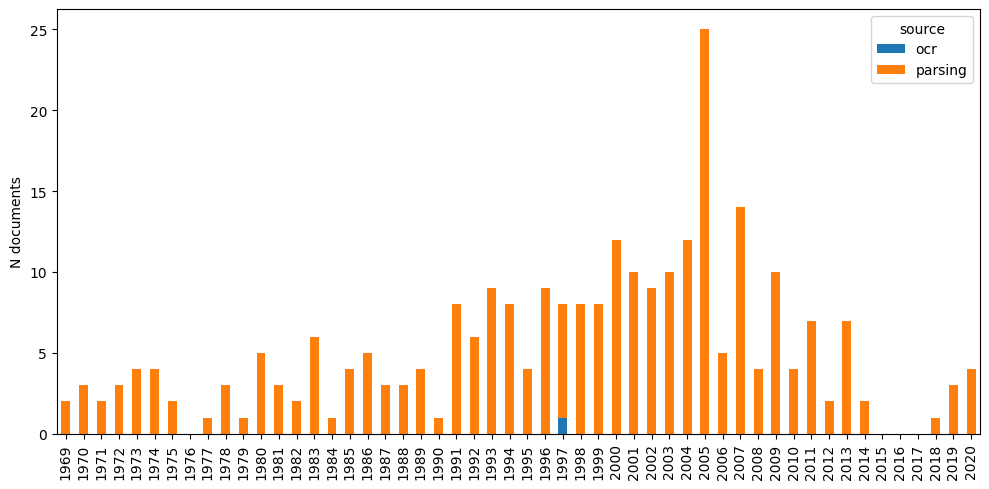

In [9]:
df_full_emb['year_'] = pd.to_datetime(df_full_emb['year'], format='%Y')
all_years = pd.date_range(start=df_full_emb['year_'].min(), end=df_full_emb['year_'].max(), freq='Y').year

proportions = df_full_emb.groupby(['year', 'source']).size().unstack(fill_value=0) #.apply(lambda x: x / x.sum(), axis=1)
proportions = proportions.reindex(all_years, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('N documents')
plt.tight_layout()
plt.savefig('fig/source_breakdown.png', dpi=300)

In [10]:
def get_file_paths(folder_path: str) -> tuple[list, list]:
    """
    """

    pdf_paths = []
    other_paths = []
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.endswith('.pdf'):
                pdf_paths.append(filepath)
            else:
                other_paths.append(filepath)

    return pdf_paths, other_paths

pdf_paths, other_paths = get_file_paths('../data/raw/UTA publications/')
pdf_paths = [path[3:] for path in pdf_paths]
len(pdf_paths)

275

In [11]:
# which docs are not overlapping
set(pdf_paths) - set(meta['path'].unique().tolist())

{'data/raw/UTA publications/UF Papers 2007-2008 copy/F &F ToM ANCR 08.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/F&F Implic-Explic 08.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/F&F Implicit:Explicit 08.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/F&F Preprint implicit:explicit.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/F&F SocCog CurrBio 07.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Frith Q&A.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Frith+Frith in Rutter.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/HamiltonBrindleyFrith_NPsy_2007.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Hirschfeld Stereotypes.07.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Hirschfeld et al. Stereotypes Autism 2007 (1).pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Italian-Chapter-Paulesu-Frith.pdf',
 'data/raw/UTA publications/UF Papers 2007-2008 copy/Klein Zwickel Pr

In [12]:
df_.query('section == "b"').groupby('warning').size()

warning
ok :)    272
dtype: int64

In [13]:
df_.query('section == "b"').groupby('source').size()

source
ocr          1
parsing    271
dtype: int64

We have two types of documents:
- `parsing`: PDFs with extractable text (n=154). Mostly the newer publications that were "born digitally"
- `ocr`: PDFs where we had to conduct optical character recognition ourselves (n=121).

The difference in text quality between these two types of documents is substantial; We address this by using a robust pre-trained model to acquire the representations, but need a couple more checks.  
So far, we successfully parsed 193 PDF files out of 275.  

# 2D plots

In [16]:
X_2d = UMAP(n_components=2, random_state=42, metric='cosine').fit_transform(df_full_emb['embeddings'].tolist())

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


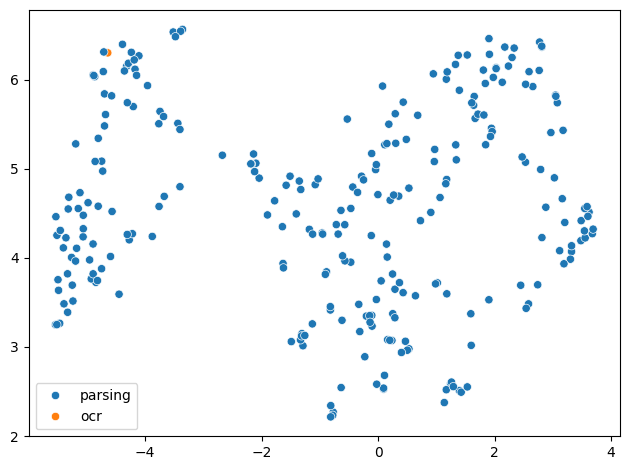

In [17]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full_emb['source'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap.png', dpi=300)

# infodynamics

In [18]:
X = df_full_emb['embeddings'].tolist()
X = np.array(X)
X.shape

(272, 1536)

In [19]:
X_prob = [calc_vector_histogram(vect, bins=100) for vect in X]
X_prob = np.array(X_prob)
X_prob.shape

(272, 100)

In [20]:
wd = WindowedRollingDistance(
    measure='jensenshannon',
    window_size=5,
    estimate_error=True
)

signal = wd.fit_transform(X_prob)

In [21]:
signal_df = pd.DataFrame(signal)
signal_df['id'] = df_full_emb['id'].tolist()
signal_df['year'] = df_full_emb['year'].tolist()
signal_df['source'] = df_full_emb['source'].tolist()
signal_df.head()

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,id,year,source
0,0.0,0.0,0.198532,0.067631,-0.198532,0.033815,p190,1969,parsing
1,0.0,0.0,0.133459,0.043797,-0.133459,0.021898,p189,1969,parsing
2,0.0,0.0,0.143772,0.044950,-0.143772,0.022475,p186,1970,parsing
3,0.0,0.0,0.232961,0.091272,-0.232961,0.045636,p188,1970,parsing
4,0.0,0.0,0.199674,0.046723,-0.199674,0.023362,p187,1970,parsing


## novelty signal

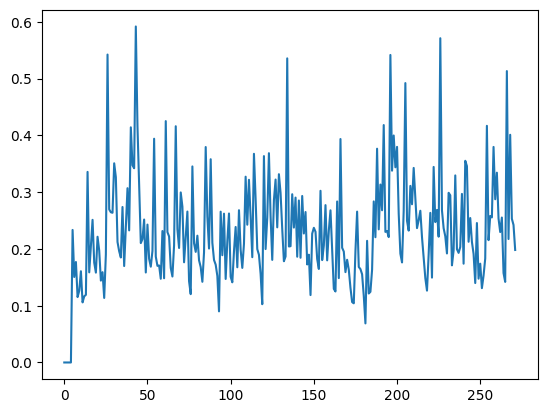

In [22]:
plt.plot(signal['N_hat'])

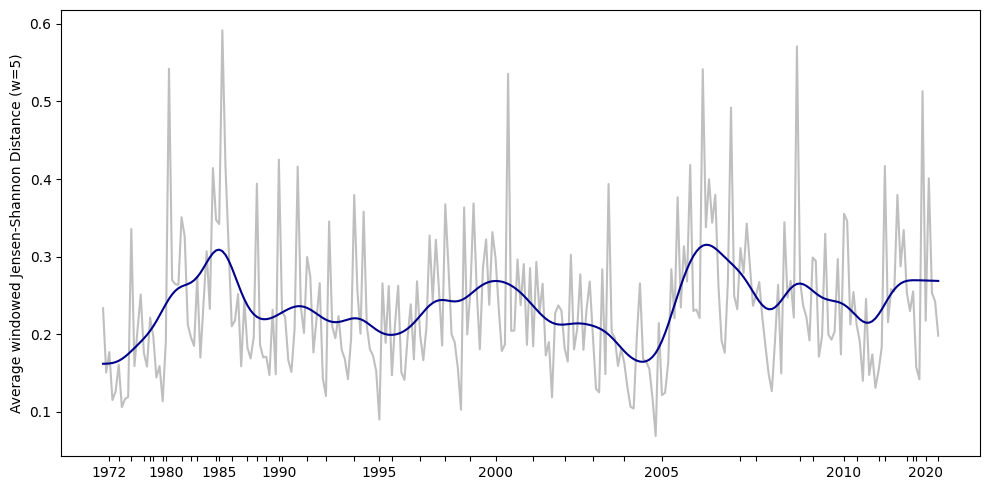

In [23]:
n_df = signal_df.iloc[5:, :]
n_hat = n_df['N_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_hat, c='grey', alpha=0.5)
ax.plot(
    gaussian_filter1d(n_hat, sigma=5), c='darkblue'
)

xticks_idx_n, xticks_label_n = generate_xticks(n_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1975]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel('Average windowed Jensen-Shannon Distance (w=5)')

plt.tight_layout()
# plt.savefig('fig/novelty_w5.png', dpi=300)

### peaks

In [24]:
n_df.query('N_hat > 0.5')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,id,year,source
26,0.542311,0.063271,0.684819,0.054653,-0.142508,0.058962,p162,1980,parsing
43,0.591794,0.151391,0.302343,0.125179,0.289451,0.138285,p127,1985,parsing
134,0.535611,0.027327,0.449013,0.103804,0.086598,0.065565,p174,2000,parsing
196,0.541625,0.112726,0.379710,0.245203,0.161914,0.178965,p44,2005,parsing
226,0.571082,0.129513,0.524152,0.018760,0.046930,0.074136,p15,2007,parsing
266,0.513234,0.102460,0.566187,0.090888,-0.052954,0.096674,p67,2019,parsing


In [25]:
peak_ids = n_df.query('N_hat > 0.5')['id'].tolist()

meta.query('id == @peak_ids').sort_values('year')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1980/Frith, The world of two dimensional space.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1985/Frith, The usefulness of the concept of unexpected reading failure.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/2000/Abell, Happe and Frith, Do triangles play tricks.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf',
 'data/raw/publications_manual_export/UTA publications/UF Papers 2007-2008 copy/Italian-Chapter-Paulesu-Frith.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2014 - 2021 copy/Fast Lane to Slow Science TICS 2019.pdf']

- 1991 peak: The cognitive explanation of autism (MRC News)
- 1997 peak: The Brain Basis of Belief (MRC Cognitive Development Unit, Information Bulletin)
- 2005 peak 1: Autism spectrum disorder (Primer in Current Biology)
- 2005 peak 2: Brain abnormalities underlying altered activation in dyslexia: a voxel based morphometry study (in Brain)
- 2006 peak: A double dissociation between sensorimotor impairments and reading disability: A comparison of autistic and dyslexic children (in Cognitive Neuropsychology)

In [26]:
meta.query('id == "p44"')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf']